2024-12-04: Visualisering av ett CNN. Hur en bild behandlas i ett redan tränat nätverk.

In [ ]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

model = keras.models.load_model('data/convnet_from_scratch_with_augmentation.keras')
model.summary()

Läs in bilden som vi ska analysera:

In [5]:
img_path = keras.utils.get_file(fname='cat.jpg', origin='https://img-datasets.s3.amazonaws.com/cat.jpg')

Visa bilden mha matplotlib:

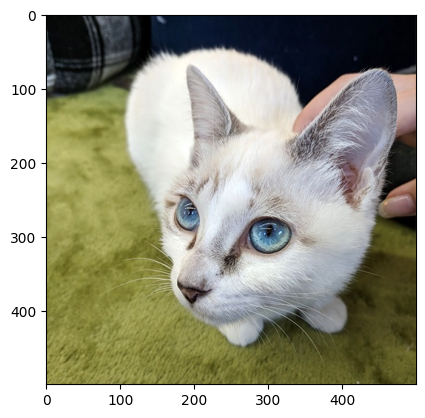

In [6]:
plt.imshow(plt.imread(img_path))

#### Skapa en ny modell som kan visa hur datan förändras i de olika stegen
Koden nedan skapar en ny modell "activation_model" som outputar "the activations" av ett specifikt lager från en existerande modell.  
Först skapas två tomma listor, i vilka outputs ska sparas angående det neurala nätverkets olika layers.  
for loopen itererar över nätverkets olika lager. Om lagret är instans av antingen Conv2D eller MaxPooling2D så sparas dess namn i "layer_names" och "layer_output".  
  
`layer.output` refererar till output tensorn av ett specifikt lager i det neurala nätverket.  
  
En ny modell som heter "activation_model" skapas. Den här modellen kommer outputta "the activations" av de specificerade lagren givet en iput.
Dett är kort ett sätt att kunna utforska hur de olika lagren processar datan genom de olika lagren.

In [7]:
layers_output = []
layer_names = []

for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_names.append(layer.name)
        layers_output.append(layer.output)

activation_model = keras.Model(inputs=model.input, outputs=layers_output)

#### Preprocessa bilden så den kan vara input till ett neuralt nätverk (skapa en tensor):
Definierar en funktion som tar två argument: path till en bild och dess size. Den preprocessas sedan för att kunna vara input till ett neuralt nätverk.  
  
Läser in image-filen och resizar till vald storlek:  
`img = keras.preprocessing.image.load_img(img_path, target_size=size)`  
  
Konverterar bilden till en numpy array, ett numeriskt format som kan processas av ett neuralt nätverk. Arrayen har tre dimensioner: height, width och tre channels för RGB om det är en färgbild (height, width, channels):  
`img_array = keras.preprocessing.image.img_to_array(img)`  
  
Adderar ytterligare en dimension som representerar batch size, vilket krävs av de flesta neurala nätverk:  
`img_array = np.expand_dims(img_array, axis=0)`  
  
Returnerar den preprocessade bilden som en tensor:  
`return img_array`

In [ ]:
def get_img_array(img_path, size):
    """Returns image as tensor with specified size,
    also adds a dimension to represent batch size"""
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

Skapar en tensor av den bilden som vi ska analysera. Använder funkionen som definierats ovan.

In [13]:
img_tensor = get_img_array(img_path, size=(180, 180))
img_tensor.shape

(1, 180, 180, 3)

Skapar "activations" (dvs output från varje lager i det neurala nätverket).  
Här används "predict" metoden med bild-tensorn som argument.

In [10]:
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


In [11]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


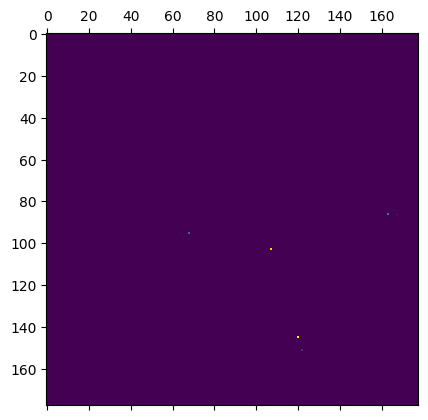

In [12]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

#### Visualisera aktiveringarna i varje lager i det neurala nätverket:  
Visar hur modellen processar inputs och vilka features som upptäcks i de olika stegen.

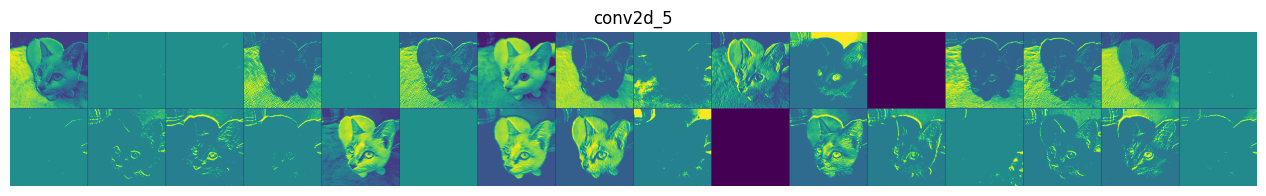

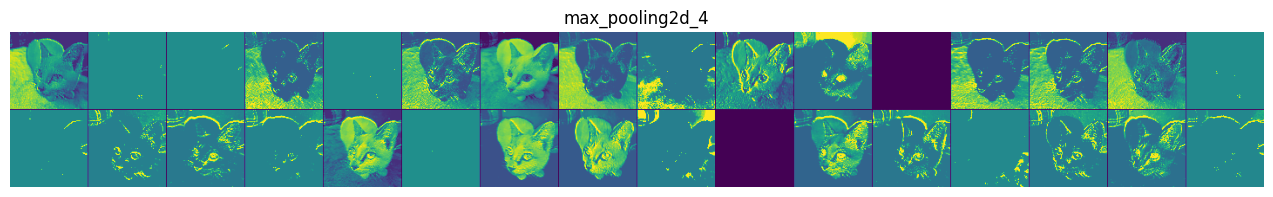

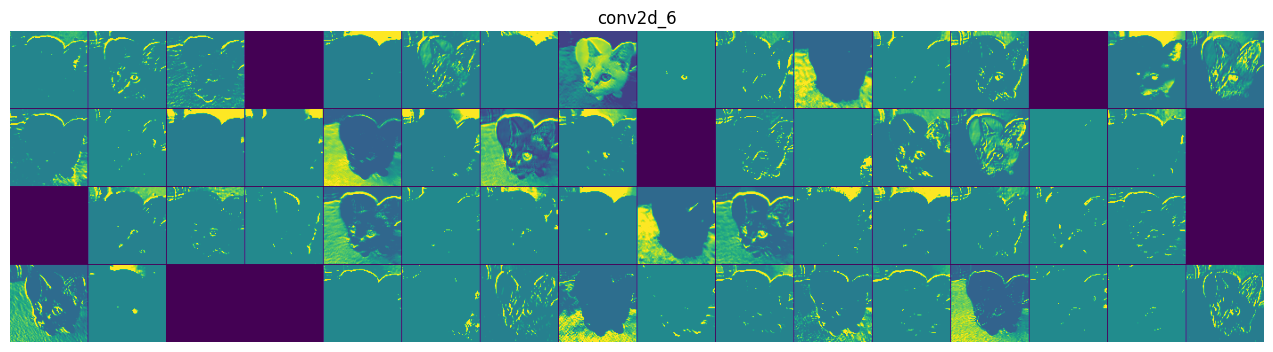

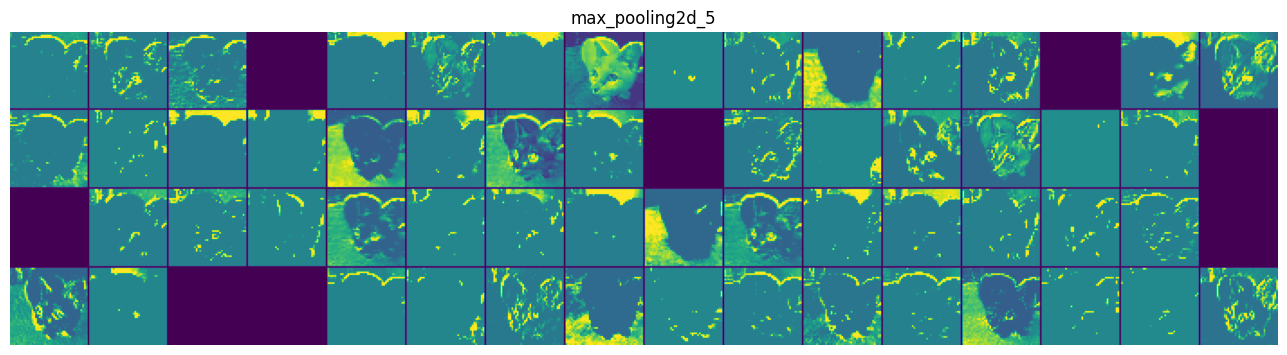

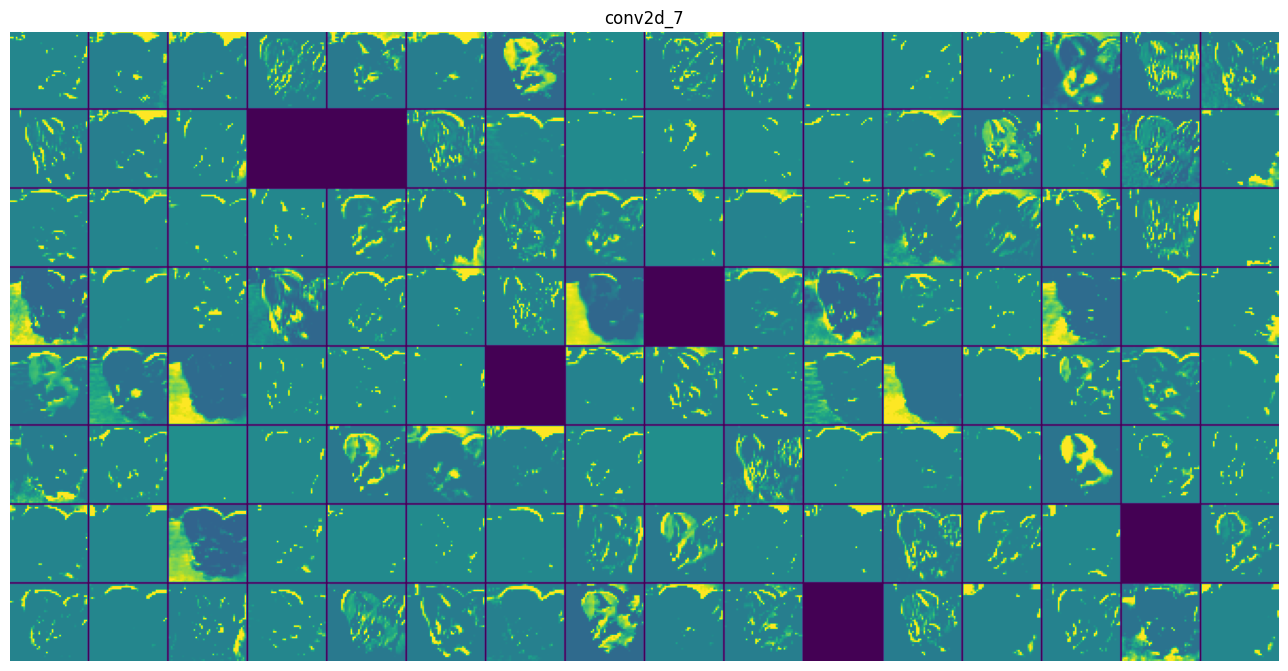

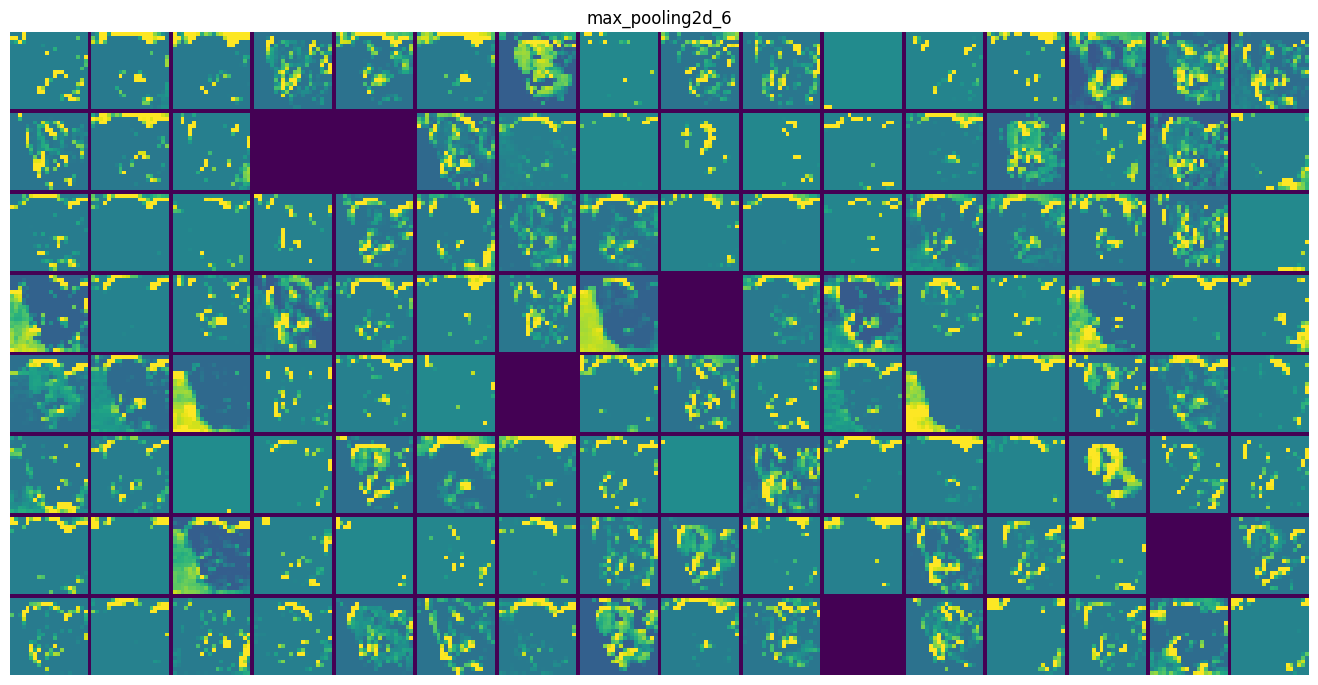

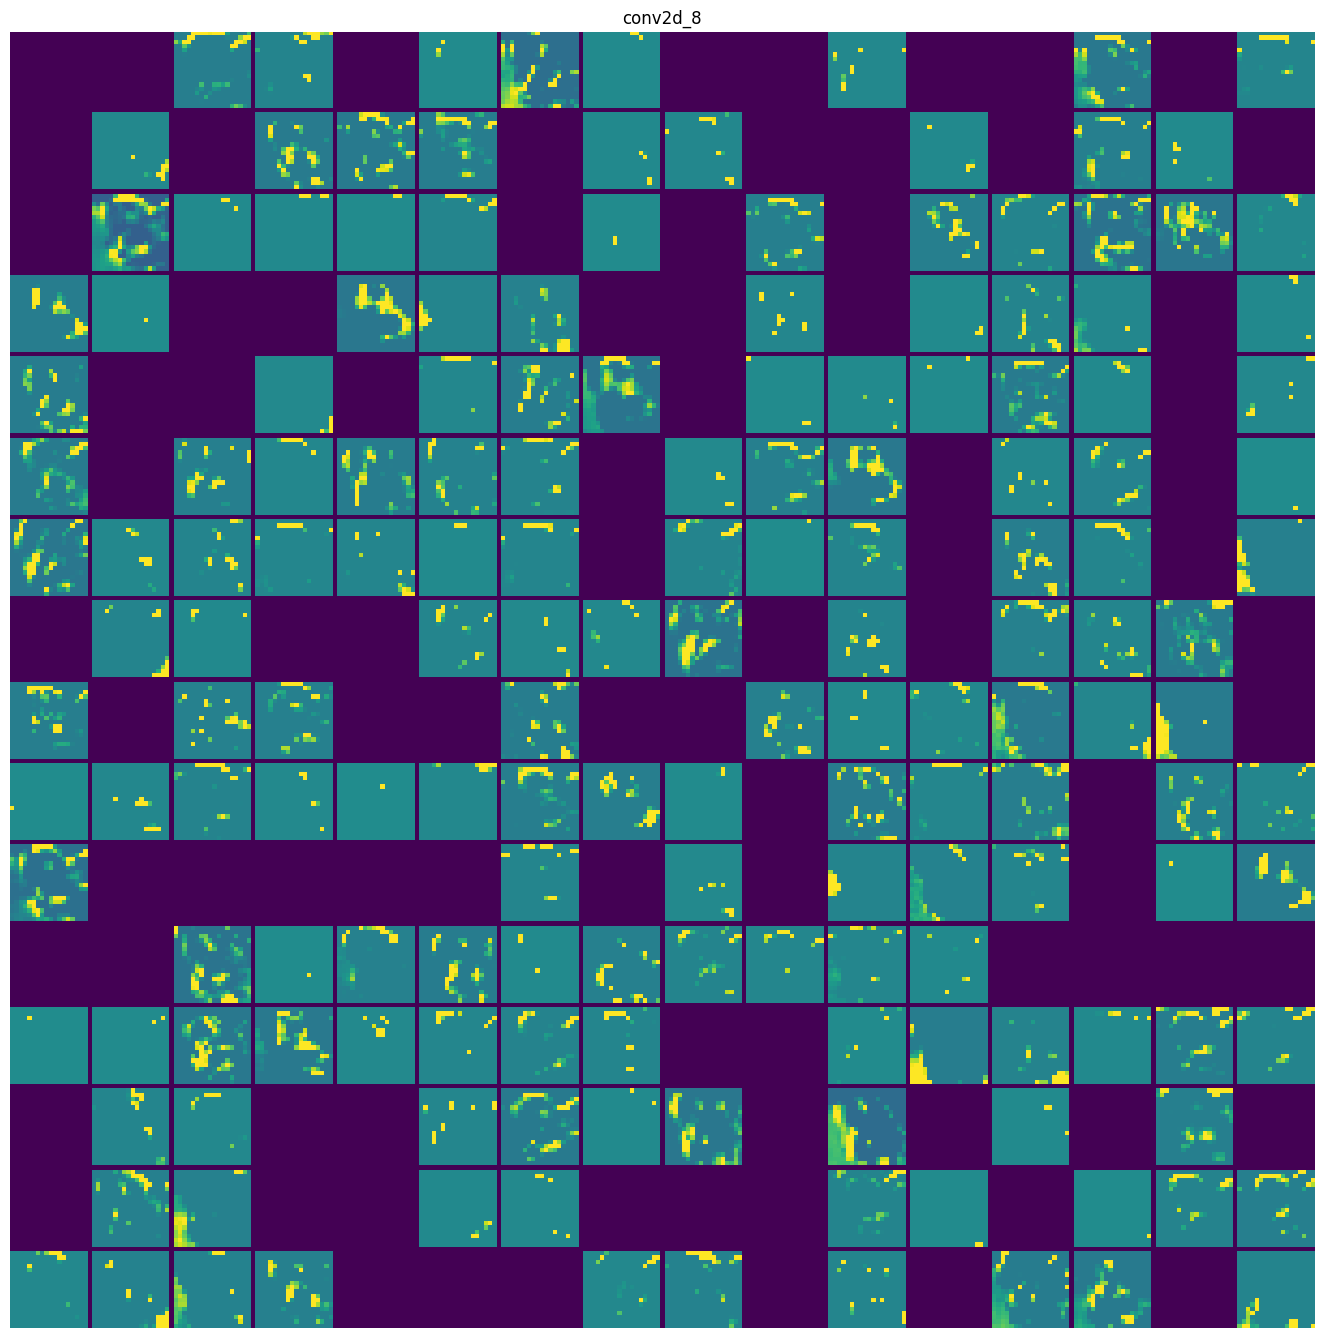

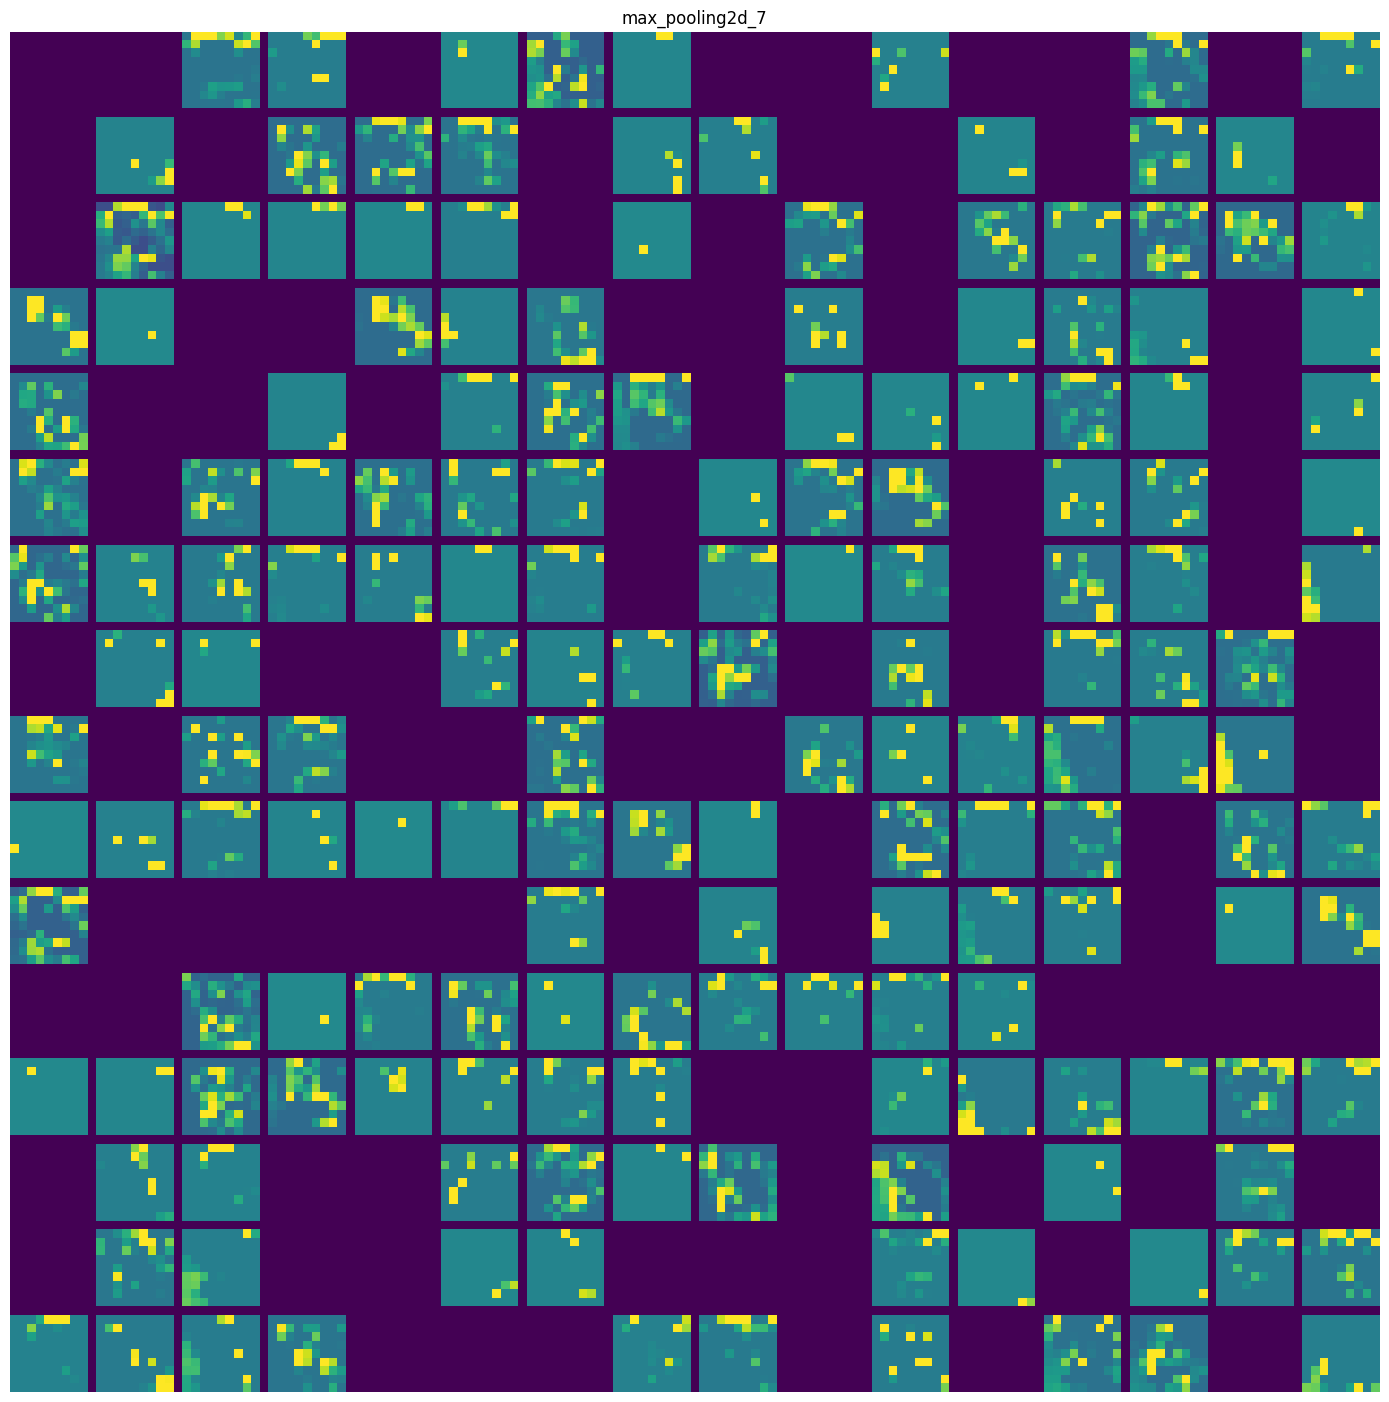

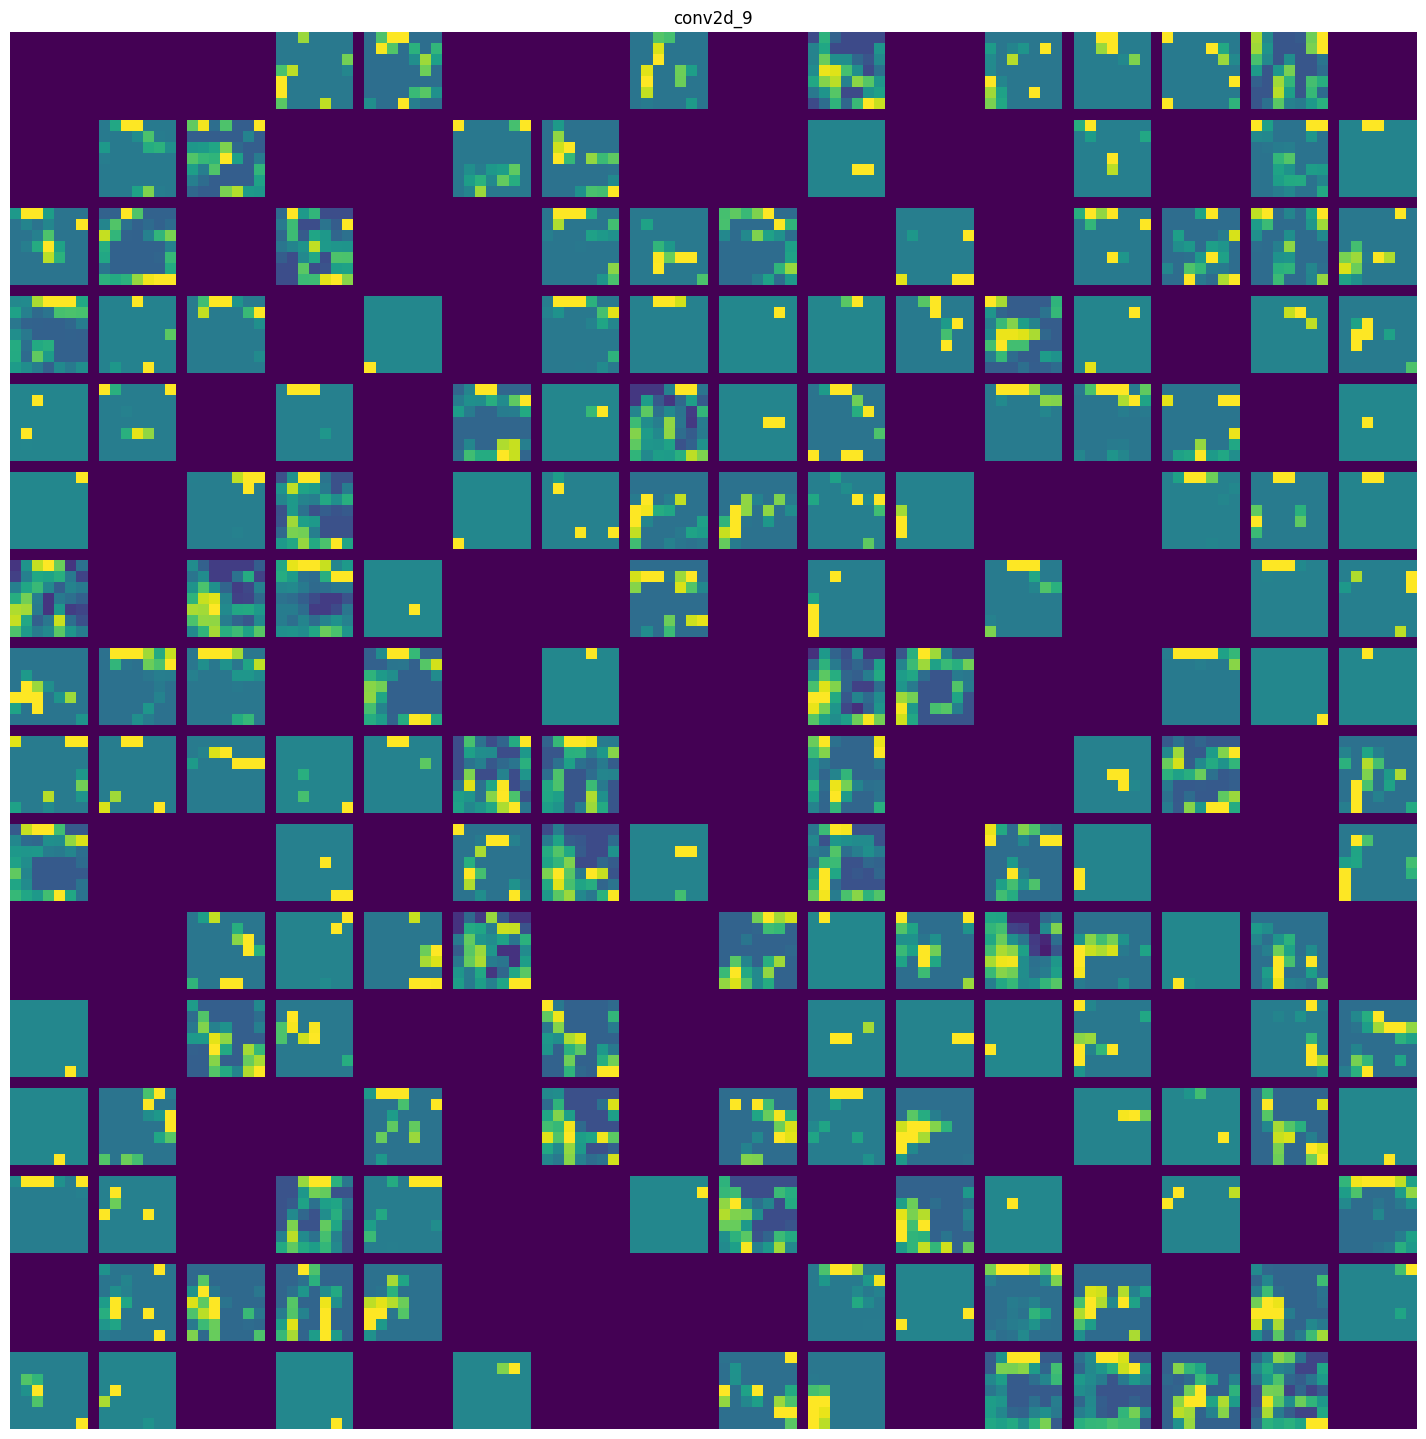

In [14]:
images_per_row = 16
for layer_name, layers_activation in zip(layer_names, activations):
    n_features = layers_activation.shape[-1]
    size = layers_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size+1) *n_cols-1,
                            images_per_row*(size+1) -1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layers_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size+1):(col+1)*size+col,
                row * (size+1): (row+1)*size+row] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                        scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")